In [1]:
import matplotlib.pyplot as plt

from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.polynomials import noll_to_nm, zernike_nm_sequence, sum_of_2d_modes
from prysm.geometry import circle

from katsu.mueller import (
    linear_diattenuator,
    linear_retarder
)

from katsu.katsu_math import np, set_backend_to_jax

def plot_square(x,n=2,vmin=None,vmax=None):
    k = 1
    plt.figure(figsize=[10,10])
    for i in range(n):
        for j in range(n):
            plt.subplot(n,n,k)
            plt.imshow(x[..., i, j], vmin=vmin, vmax=vmax, cmap='RdBu_r')
            plt.colorbar()
            k += 1
    plt.show()

## 1. Rotation of Zernike Polynomials

In [2]:
x, y = make_xy_grid(128, diameter=1)
r, t = cart_to_polar(x, y)
nms = [noll_to_nm(i) for i in range(1,37)]
basis = list(zernike_nm_sequence(nms, r, t))
basis_rotated = list(zernike_nm_sequence(nms, r, t + np.pi/4))
A = circle(0.5, r)
coeffs = np.random.random(len(basis))
data = sum_of_2d_modes(basis, coeffs)
data_rotated = sum_of_2d_modes(basis_rotated, coeffs)

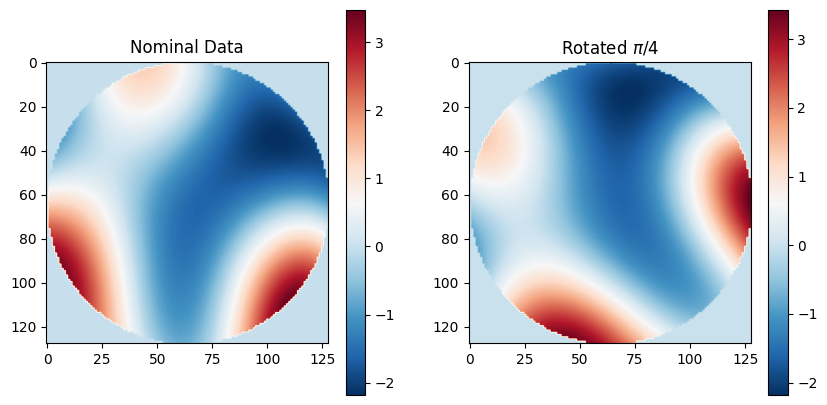

In [3]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('Nominal Data')
plt.imshow(data * A, cmap='RdBu_r')
plt.colorbar()
plt.subplot(122)
plt.title('Rotated '+r'$\pi/4$')
plt.imshow(data_rotated * A, cmap='RdBu_r')
plt.colorbar()
plt.show()

## 2. Expressing a Polarizer with a Modal Basis

In [4]:
help(linear_diattenuator)
scale = 100
coeffs_angle_diattenuator = np.random.random(len(basis)) / scale
coeffs_trans_diattenuator = np.random.random(len(basis)) / scale

angle_diattenuator = sum_of_2d_modes(basis, coeffs_angle_diattenuator) * A
trans_diattenuator = sum_of_2d_modes(basis, coeffs_trans_diattenuator) * A
trans_diattenuator -= np.min(trans_diattenuator)

psg_dia = linear_diattenuator(angle_diattenuator, trans_diattenuator, shape=basis[0].shape)

Help on function linear_diattenuator in module katsu.mueller:

linear_diattenuator(a, Tmin, Tmax=1, shape=None)
    returns a homogenous linear diattenuator
    
    CLY 6.54
    
    Parameters
    ----------
    a : float, or numpy.ndarray
        angle of the transmission axis w.r.t. horizontal in radians. If numpy
        array, must be the same shape as `shape`
    Tmin : float, or numpy.ndarray
        Minimum transmission of the state orthogonal to maximum transmission. 
        If numpy array, must be the same shape as `shape`
    shape : list, optional
        shape to prepend to the mueller matrix array, see `_empty_mueller`. 
        By default None
    
    Returns
    -------
    numpy.ndarray
        linear diattenuator array



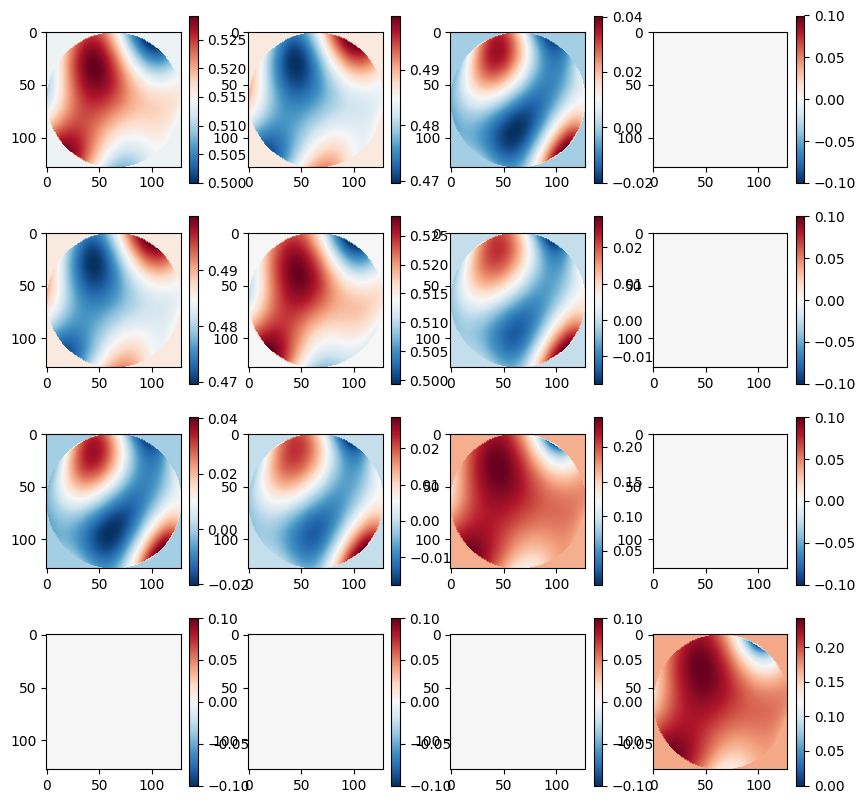

In [5]:
vlim = None
plot_square(psg_dia, n=4, vmin=vlim, vmax=vlim)

## 3. Data Reduction with spatially-varying polarizers
What parameters require optimization? We have 
- $\mathbf{T}_{g}(\mathbf{r}, \mathbf{\theta})$, the minimum transmission of the PSG polarizer
- $\mathbf{\Phi}_{g}(\mathbf{r}, \mathbf{\theta})$, the angle of transmission of the PSG polarizer
- $\mathbf{\Delta}_{g}(\mathbf{r}, \mathbf{\theta})$, the retardance of the PSG retarder
- $\mathbf{\Psi}_{g}(\mathbf{r}, \mathbf{\theta})$, the fast axis of the PSG retarder
- $\mathbf{T}_{a}(\mathbf{r}, \mathbf{\theta})$, the minimum transmission of the PSA polarizer
- $\mathbf{\Phi}_{a}(\mathbf{r}, \mathbf{\theta})$, the angle of transmission of the PSA polarizer
- $\mathbf{\Delta}_{a}(\mathbf{r}, \mathbf{\theta})$, the retardance of the PSA retarder
- $\mathbf{\Psi}_{a}(\mathbf{r}, \mathbf{\theta})$, the fast axis of the PSA retarder
- $\theta_{p,g}$, the angular offset of the PSG polarizer
- $\theta_{r,g}$, the angular offset of the PSG retarder
- $\Theta_{r,g}$, the angular increment of the PSG retarder
- $\theta_{p,a}$, the angular offset of the PSA polarizer
- $\theta_{r,a}$, the angular offset of the PSA retarder
- $\Theta_{r,a}$, the angular increment of the PSA retarder

The bold quantities are of shape $N_{modes}$ and the remaining are individuals. We can pack the gradients by appending them to an array. In total, we need $8 \times N_{modes} + 6$ free parameters

In [6]:
# Set up the optics
coeffs_spatially_varying = np.random.random([8, len(basis)]) / 10
theta_pg = 0
theta_rg = 0
Theta_rg = np.radians(10)
theta_pa = np.radians(90)
theta_ra = 0
Theta_ra = np.radians(10)

NMEAS = 26

In [7]:
help(np.broadcast_to)

Help on _ArrayFunctionDispatcher in module numpy:

broadcast_to(array, shape, subok=False)
    Broadcast an array to a new shape.
    
    Parameters
    ----------
    array : array_like
        The array to broadcast.
    shape : tuple or int
        The shape of the desired array. A single integer ``i`` is interpreted
        as ``(i,)``.
    subok : bool, optional
        If True, then sub-classes will be passed-through, otherwise
        the returned array will be forced to be a base-class array (default).
    
    Returns
    -------
    broadcast : array
        A readonly view on the original array with the given shape. It is
        typically not contiguous. Furthermore, more than one element of a
        broadcasted array may refer to a single memory location.
    
    Raises
    ------
    ValueError
        If the array is not compatible with the new shape according to NumPy's
        broadcasting rules.
    
    See Also
    --------
    broadcast
    broadcast_arrays
    

### PSG Polarizer

In [8]:
trans_psg_pol = sum_of_2d_modes(basis, coeffs_spatially_varying[0])
trans_psg_pol -= trans_psg_pol.min()
angle_psg_pol = sum_of_2d_modes(basis, coeffs_spatially_varying[1])


psg_pol = linear_diattenuator(angle_psg_pol + theta_pg,
                              trans_psg_pol,
                              shape=[*angle_psg_pol.shape, NMEAS])

In [9]:
a = np.random.random([128,128])
b = np.random.random([128,128,1])
c = a * b
c.shape

(128, 128, 128)

In [10]:
isinstance(angle_psg_pol, np.ndarray)

True

### PSG Retarder

In [13]:
retar_psg_wvp = sum_of_2d_modes(basis, coeffs_spatially_varying[2])
angle_psg_wvp = sum_of_2d_modes(basis, coeffs_spatially_varying[3])
rotations = np.linspace(0, np.radians(180), NMEAS)

psg_wvp = linear_retarder(angle_psg_wvp + rotations,
                          retar_psg_wvp,
                          shape=[*angle_psg_wvp.shape, NMEAS])
plot_square(psg_wvp[:,:,0], n=4)

ValueError: operands could not be broadcast together with shapes (128,128) (26,) 

### PSA Retarder

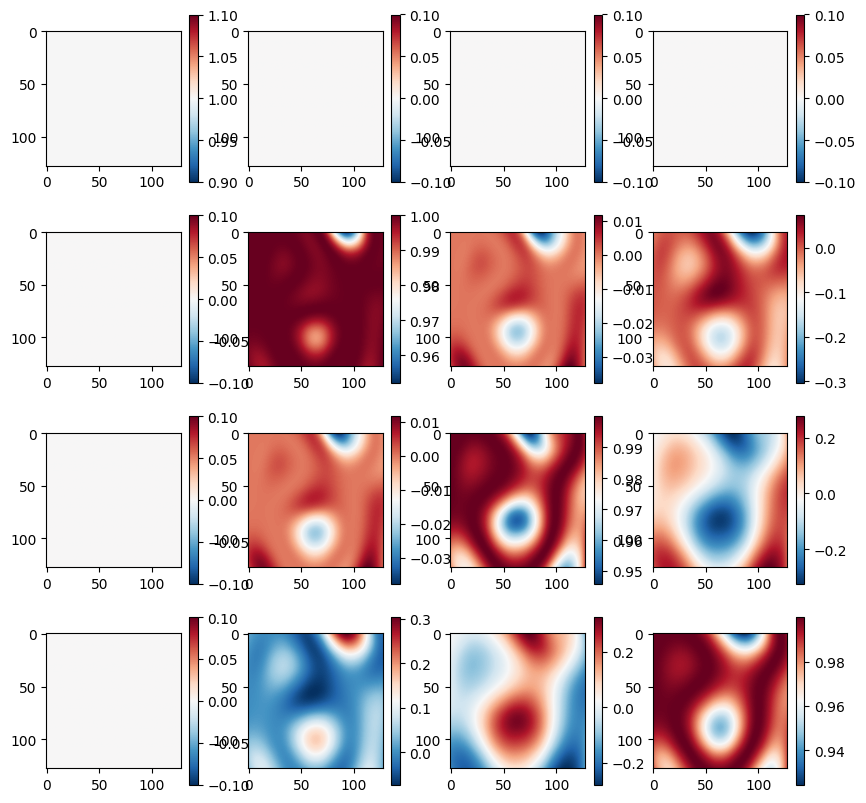

In [ ]:
retar_psa_wvp = sum_of_2d_modes(basis, coeffs_spatially_varying[4])
angle_psa_wvp = sum_of_2d_modes(basis, coeffs_spatially_varying[5])

psa_wvp = linear_retarder(angle_psa_wvp, retar_psa_wvp, shape=angle_psg_wvp.shape)
plot_square(psa_wvp, n=4)

### PSA Polarizer

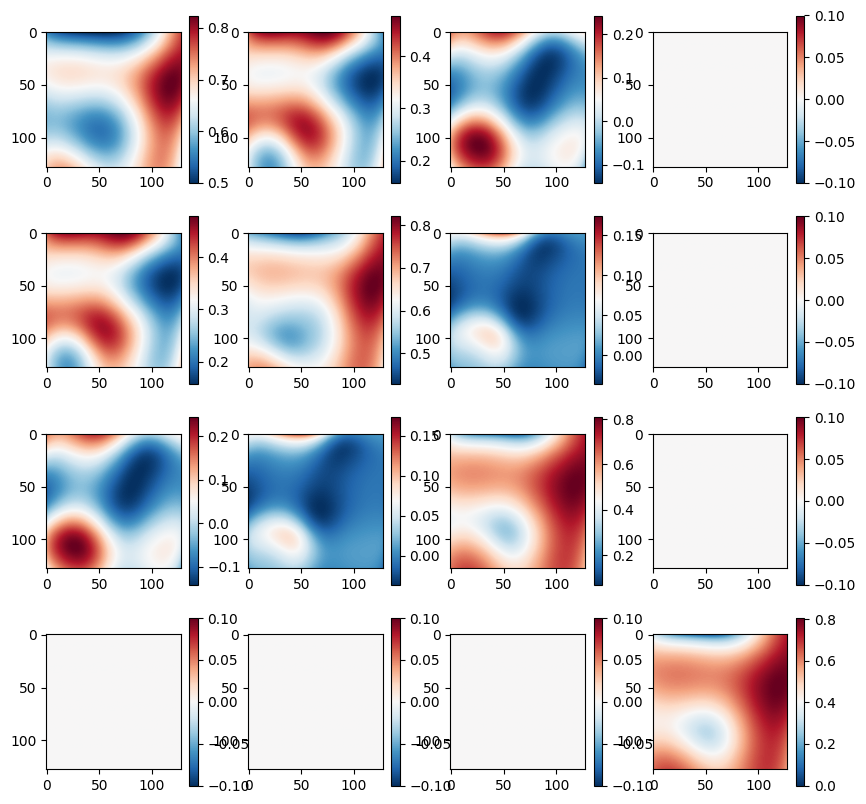

In [ ]:
trans_psa_pol = sum_of_2d_modes(basis, coeffs_spatially_varying[6])
trans_psa_pol -= trans_psa_pol.min()
angle_psa_pol = sum_of_2d_modes(basis, coeffs_spatially_varying[7])

psa_pol = linear_diattenuator(angle_psa_pol, trans_psa_pol, shape=angle_psa_pol.shape)
plot_square(psa_pol, n=4)

### The Forward Model